📈 Fetching AUDCAD (AUDCAD=X)...
YF.download() has changed argument auto_adjust default to True
📈 Fetching AUDCHF (AUDCHF=X)...
📈 Fetching AUDJPY (AUDJPY=X)...
📈 Fetching AUDNZD (AUDNZD=X)...
📈 Fetching AUDUSD (AUDUSD=X)...
📈 Fetching CADCHF (CADCHF=X)...
📈 Fetching CADJPY (CADJPY=X)...
📈 Fetching CHFJPY (CHFJPY=X)...
📈 Fetching EURAUD (EURAUD=X)...
📈 Fetching EURCAD (EURCAD=X)...
📈 Fetching EURCHF (EURCHF=X)...
📈 Fetching EURGBP (EURGBP=X)...
📈 Fetching EURJPY (EURJPY=X)...
📈 Fetching EURMXN (EURMXN=X)...
📈 Fetching EURNZD (EURNZD=X)...
📈 Fetching EURUSD (EURUSD=X)...
📈 Fetching EURZAR (EURZAR=X)...
📈 Fetching GBPAUD (GBPAUD=X)...
📈 Fetching GBPCAD (GBPCAD=X)...
📈 Fetching GBPCHF (GBPCHF=X)...
📈 Fetching GBPJPY (GBPJPY=X)...
📈 Fetching GBPMXN (GBPMXN=X)...
📈 Fetching GBPNZD (GBPNZD=X)...
📈 Fetching GBPUSD (GBPUSD=X)...
📈 Fetching GBPZAR (GBPZAR=X)...
📈 Fetching NZDCAD (NZDCAD=X)...
📈 Fetching NZDCHF (NZDCHF=X)...
📈 Fetching NZDJPY (NZDJPY=X)...
📈 Fetching NZDUSD (NZDUSD=X)...
📈 Fetchin

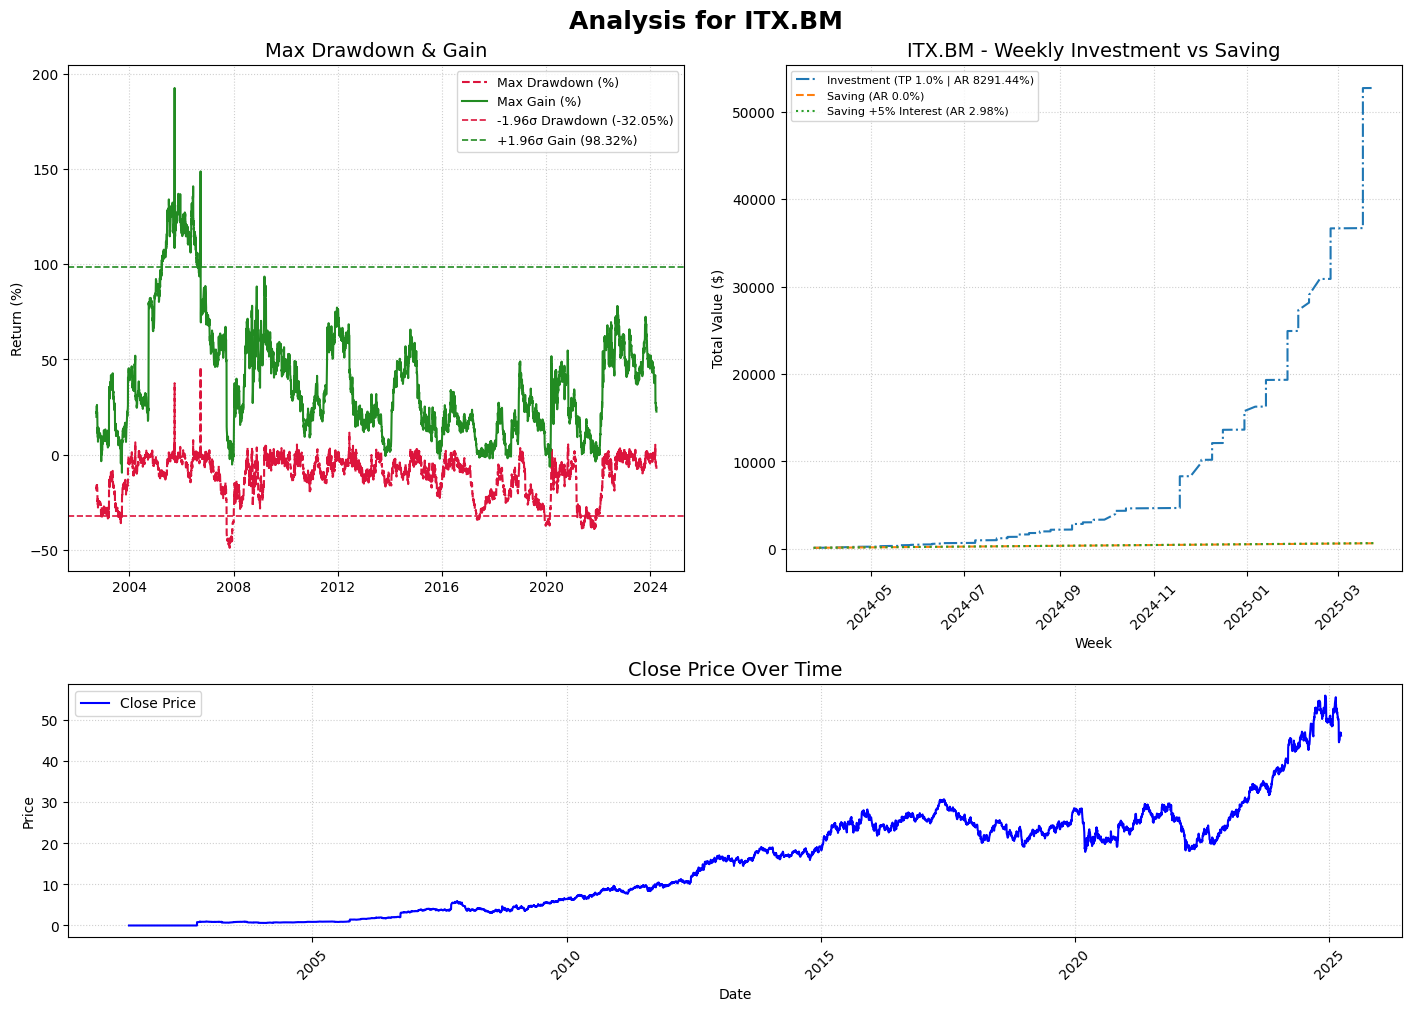


📊 Analyzing AUDCAD...


In [ ]:
import os
from data_fetcher import YahooFinanceDataFetcher
from google_sheet_api import GoogleSheetsUploader
from analyzer import run_analysis, run_all_analyses

# ========== Setup ========== #
BASE_DIR = os.getcwd()
CONFIG_PATH = os.path.join(BASE_DIR, "config.yaml")
CREDENTIAL_PATH = os.path.join(BASE_DIR, "credential_google_sheets.json")
PLOTS_DIR = os.path.join(BASE_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# ========== Parameters ========== #
STD_MULTIPLIER = 1.96
initial_balance = 100
invest_per_week = 10
tp_percent = 1.0
leverage = 1000
min_years_required = 1

def main():
    # ========== Fetch All Data ========== #
    fetcher = YahooFinanceDataFetcher(CONFIG_PATH)
    full_df = fetcher.get_data()
    symbol_list = full_df["Symbol"].unique()

    # ========== Run Analysis ========== #
    symbol = "ITX.BM"
    data, dd_thresh, gain_thresh = run_analysis(
        df=full_df,
        symbol=symbol,
        std_multiplier=STD_MULTIPLIER,
        plots_dir=PLOTS_DIR,
        tp_percent=tp_percent,
        leverage=leverage,
        coeff=fetcher.coeff_map.get(symbol),
        initial_balance=initial_balance,
        invest_per_week=invest_per_week,
        min_years_required=min_years_required
    )

    # ========== Run All Analyses ========== #
    df = run_all_analyses(
        full_df=full_df,
        symbol_list=symbol_list,
        std_multiplier=STD_MULTIPLIER,
        plots_dir=PLOTS_DIR,
        tp_percent=tp_percent,
        leverage=leverage,
        coeff_map=fetcher.coeff_map,
        initial_balance=initial_balance,
        invest_per_week=invest_per_week,
        min_years_required=min_years_required
    )

    # --- Upload to Google Sheets ---
    try:
        print("\n📤 Uploading to Google Sheets...")
        uploader = GoogleSheetsUploader(CREDENTIAL_PATH, "Financial Report - Indonesia")
        uploader.upload_dataframe(df, "Overview")
        print("✅ Upload successful!")
    except Exception as e:
        print(f"❌ Upload failed: {e}")

    df

if __name__ == "__main__":
    main()